# Entities

## Init

### Imports

In [1]:
import sys
sys.path.append('..')

In [2]:
import spacy
import random
import string
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from spacy import displacy
from itertools import chain
from hd_utils import monitor
from collections import Counter
from sklearn.datasets.lfw import Bunch

### Plot

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

### Args

In [4]:
args = Bunch()

## Spacy 101

In [5]:
sample_text = '''But Google is starting from behind. The company made a late push \
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa \
software, which runs on its Echo and Dot devices, have clear leads in \
consumer adoption.'''
sample_text

'But Google is starting from behind. The company made a late push into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa software, which runs on its Echo and Dot devices, have clear leads in consumer adoption.'

In [6]:
nlp = spacy.load('en')
doc = nlp(sample_text)

In [7]:
for token in doc[:10]:
    print(f'text={token.text} lemma={token.lemma_} pos={token.pos_}')

text=But lemma=but pos=CCONJ
text=Google lemma=google pos=PROPN
text=is lemma=be pos=VERB
text=starting lemma=start pos=VERB
text=from lemma=from pos=ADP
text=behind lemma=behind pos=ADV
text=. lemma=. pos=PUNCT
text=The lemma=the pos=DET
text=company lemma=company pos=NOUN
text=made lemma=make pos=VERB


In [8]:
print([chunk.text for chunk in doc.noun_chunks])

['Google', 'The company', 'a late push', 'hardware', 'Apple', 'Siri', 'iPhones', 'Amazon’s Alexa software', 'its Echo', 'Dot devices', 'clear leads', 'consumer adoption']


In [9]:
options = {'compact': True, 'bg': '#09a3d5',
           'color': 'white', 'font': 'Source Sans Pro'}
displacy.render(nlp(next(doc.sents).text), style='dep', options=options, jupyter=True)

In [10]:
doc.user_data['title'] = 'Apple vs Google'
displacy.render(doc, style='ent', jupyter=True)

## Read

In [11]:
args.data_text_path = 'docstring_data_text.hdf5'

In [12]:
%time df = pd.read_hdf(args.data_text_path)
df.shape

CPU times: user 1.41 s, sys: 160 ms, total: 1.57 s
Wall time: 299 ms


(149507, 1)

In [13]:
df.head()

,text
0,Find globals in this statement.
1,Returns True if the input phrase has a negativ...
2,Returns True if the input phrase has a positiv...
3,Returns: DCNL A speaker implementation availab...
4,Gets the keyword phrases from the keywords fil...


## Collect entities

In [14]:
args.informative_poses = {'NOUN', 'PROPN'}
args.stop_words = {"doesn\\'t", 'it\\', 'user\\', 'return', ':return'}
args.log_step = 5000
args.good_chars = string.ascii_lowercase + ' '

In [15]:
def fetch_entity(desc):
    def norm(word):
        return word.strip().lower()
    
    def is_valid(word):
        return not nlp.vocab[word].is_stop \
                    and not 'dcnl' in word \
                    and not '_' in word and len(word) > 1 \
                    and not word in args.stop_words \
                    and all(char in args.good_chars for char in word)
    
    # Forming candidates
    doc = nlp(desc)
    ents = (ent.text for ent in doc.ents)
    lemmas = (token.lemma_ for token in doc \
              if token.pos_ in args.informative_poses and not token.lemma_.startswith('-'))
    noun_chunks = (chunk.text for chunk in doc.noun_chunks)
    candidates = (norm(candidate) for candidate in chain(ents, lemmas, noun_chunks))
    
    return set(candidate for candidate in candidates if is_valid(candidate))

In [16]:
@monitor('[1.3.1] Collect entities', log_step=args.log_step, log_total=len(df))
def collect_entities(descs, *, log):
    entities = []
    for i, desc in enumerate(tqdm(descs)):
        entities.append(fetch_entity(desc))
        log.istep(i)
    return entities

In [17]:
entities = collect_entities(df.text)
assert len(df) == len(entities)
random.sample(entities, 1)

100%|██████████| 149507/149507 [51:59<00:00, 47.93it/s]


[{'cache', 'entries', 'entry', 'sweep', 'the cache'}]

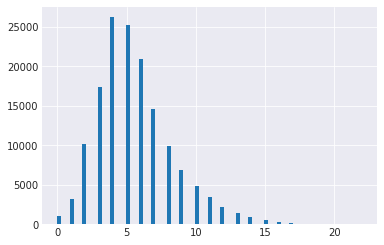

In [18]:
pd.Series([len(i_entities) for i_entities in entities]).hist(bins=75);

## Analysis

In [19]:
@monitor('[1.3.2] Join entities', log_step=args.log_step, log_total=len(entities))
def join_entities(entities, *, log):
    cum_cnt = Counter()
    for i, entity in enumerate(tqdm(entities)):
        cum_cnt += Counter(entity)
        log.istep(i)
    return cum_cnt

In [20]:
ecnts = join_entities(entities)
len(ecnts)

100%|██████████| 149507/149507 [23:38<00:00, 105.38it/s]


146616

In [21]:
str(ecnts.most_common(50))

"[('test', 16568), ('list', 7555), ('object', 7078), ('file', 6770), ('value', 6252), ('method', 5723), ('string', 5552), ('function', 5543), ('user', 5233), ('instance', 4867), ('datum', 4129), ('request', 3639), ('param', 3257), ('type', 3151), ('returns', 3079), ('a list', 3055), ('error', 2931), ('parameter', 2909), ('number', 2873), ('message', 2798), ('argument', 2686), ('default', 2678), ('field', 2657), ('path', 2636), ('tests', 2533), ('class', 2479), ('command', 2233), ('attribute', 2120), ('key', 2116), ('api', 2098), ('response', 2078), ('state', 2028), ('information', 2027), ('result', 2024), ('exception', 2013), ('dictionary', 1966), ('line', 1953), ('server', 1931), ('module', 1916), ('group', 1898), ('connection', 1889), ('model', 1886), ('version', 1883), ('page', 1848), ('image', 1848), ('directory', 1837), ('dict', 1792), ('url', 1789), ('output', 1770), ('content', 1724)]"

In [22]:
entities = [sorted(entity, key=lambda x: ecnts[x])[:5] for entity in tqdm(entities)]
assert len(df) == len(entities)
random.sample(entities, 1)

100%|██████████| 149507/149507 [00:01<00:00, 127052.92it/s]


[['github', 'documentation']]

In [23]:
def linearize(entities):
    return ' '.join(sorted('-'.join(entity.split()) for entity in entities))

In [24]:
entities = [linearize(i_entities) for i_entities in tqdm(entities)]
assert len(df) == len(entities)
random.sample(entities, 1)

100%|██████████| 149507/149507 [00:00<00:00, 218919.42it/s]


['a-project ip ips project the-floating-ips']

In [25]:
df['tags'] = entities
df.shape

(149507, 2)

In [26]:
df.head()

,text,tags
0,Find globals in this statement.,global globals statement this-statement
1,Returns True if the input phrase has a negativ...,a-negative-sentiment arguments phrase sentimen...
2,Returns True if the input phrase has a positiv...,a-positive-sentiment arguments phrase sentimen...
3,Returns: DCNL A speaker implementation availab...,a-speaker-implementation no-speaker-implementa...
4,Gets the keyword phrases from the keywords fil...,jasper keyword-phrases the-jasper-data-dir the...


In [27]:
df = df[df.tags.map(len) > 0].copy()
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.shape

(148395, 2)

In [28]:
df.head()

,text,tags
0,Find globals in this statement.,global globals statement this-statement
1,Returns True if the input phrase has a negativ...,a-negative-sentiment arguments phrase sentimen...
2,Returns True if the input phrase has a positiv...,a-positive-sentiment arguments phrase sentimen...
3,Returns: DCNL A speaker implementation availab...,a-speaker-implementation no-speaker-implementa...
4,Gets the keyword phrases from the keywords fil...,jasper keyword-phrases the-jasper-data-dir the...


In [29]:
assert (df.index == list(range(len(df)))).all()

## Save

In [30]:
args.save_path = 'docstring_data.hdf5'

In [31]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 168 ms, sys: 36 ms, total: 204 ms
Wall time: 203 ms


In [32]:
!du -sh $args.save_path

19M	docstring_data.hdf5


## End

In [33]:
args

{'data_text_path': 'docstring_data_text.hdf5',
 'good_chars': 'abcdefghijklmnopqrstuvwxyz ',
 'informative_poses': {'NOUN', 'PROPN'},
 'log_step': 5000,
 'save_path': 'docstring_data.hdf5',
 'stop_words': {':return', "doesn\\'t", 'it\\', 'return', 'user\\'}}